# Simulation Studies

In [1]:
import sys
sys.path.insert(0,'..')
from grass_DR import *
import scipy.io
import matplotlib.pyplot as plt
from compute_centroid import *
from PGA import *
from PNG import *
from pymanopt.solvers.linesearch import LineSearchAdaptive
from tqdm import tqdm
from tabulate import tabulate
import torch

## 1. Comparison between geodesic distance and projection distance

In [2]:
p = 1
m = 3
n = 10
N = 50
repetition = 100
s_vec = np.linspace(0.01, 0.5, 20)
v_ratio_sig_proj = np.zeros((len(s_vec), repetition))
v_ratio_sig_geod = np.zeros((len(s_vec), repetition))
gr_low = Grassmann(m, p)
gr = Grassmann(n, p)
gr_map = Grassmann(n, m)

In [3]:
for j, sig in enumerate(s_vec):
    for k in range(repetition):
        X_low = np.array([gr_low.rand() for i in range(N)]) # N x m x p
        W = gr_map.rand() # n x m
        X_ = np.array([np.matmul(W, X_low[i]) for i in range(N)]) # N x n x p
        X = np.array([gr.exp(X_[i], sig * gr.randvec(X_[i])) for i in range(N)]) # perturb the emdedded X
        
        FM_X = compute_centroid(gr, X)
        var_X = var(gr, X, FM_X)
        
        X_low_proj, _, _ = NG_dr(X, m, verbosity = 0)
        X_low_geod, _, _ = NG_dr_geod(X, m, verbosity = 0)
        
        FM_proj = compute_centroid(gr_low, X_low_proj)
        var_proj = var(gr_low, X_low_proj, FM_proj)
        
        FM_geod = compute_centroid(gr_low, X_low_geod)
        var_geod = var(gr_low, X_low_geod, FM_geod)
        
        v_ratio_sig_proj[j, k] = var_proj/var_X
        v_ratio_sig_geod[j, k] = var_geod/var_X

Terminated - max iterations reached after 18.78 seconds.

Terminated - max iterations reached after 16.56 seconds.

Terminated - max iterations reached after 17.54 seconds.

Terminated - max iterations reached after 15.85 seconds.

Terminated - max iterations reached after 17.23 seconds.

Terminated - max iterations reached after 16.67 seconds.

Terminated - max iterations reached after 18.18 seconds.

Terminated - max iterations reached after 17.29 seconds.

Terminated - max iterations reached after 17.34 seconds.

Terminated - max iterations reached after 16.55 seconds.

Terminated - max iterations reached after 18.39 seconds.

Terminated - max iterations reached after 16.83 seconds.

Terminated - max iterations reached after 17.94 seconds.

Terminated - max iterations reached after 16.81 seconds.

Terminated - max iterations reached after 18.28 seconds.

Terminated - max iterations reached after 16.23 seconds.

Terminated - max iterations reached after 18.30 seconds.

Terminated - m

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.plot(s_vec, np.mean(v_ratio_sig_proj, axis = 1), '-', linewidth=3)
plt.plot(s_vec, np.mean(v_ratio_sig_geod, axis = 1), '--', linewidth=3)
plt.xlabel('$\sigma^2$')
plt.ylabel('Variance explained (%)')
plt.legend(['Proj.', 'Geod.'], loc='lower left')
plt.tight_layout()
#plt.savefig('var_sig.pdf')
plt.show()

## 2. Comparison of PNG and PGA

In [29]:
p = 2
m = 5
n = 10
N = 50
n_c = 5
repetition = 100
s_vec = np.array([0.01, 0.05, 0.1, 0.5])
v_ratio_sig_PNG = np.zeros((repetition, len(s_vec), n_c))
v_ratio_sig_PGA = np.zeros((repetition, len(s_vec), n_c))
gr_low = Grassmann(m, p, N)
gr = Grassmann(n, p)
gr_map = Grassmann(n, m)

In [30]:
for j, sig in enumerate(s_vec):
    for k in range(repetition):
        X_low = gr_low.rand() # N x m x p
        A = gr_map.rand() # n x m
        #B = np.random.normal(0, 0.1, (n, p)) # n x p
        B = np.zeros((n,p))
        AAT = np.matmul(A, A.T) 
        IAATB = np.matmul(np.eye(n) - AAT, B)
        X_ = np.array([np.linalg.qr(np.matmul(A, X_low[i]) + IAATB)[0] for i in range(N)]) # N x n x p
        X = np.array([gr.exp(X_[i], sig * gr.randvec(X_[i])) for i in range(N)]) # perturb the emdedded X
        
        scores_PNG = PNG(X, log = False, verbosity = 0)
        
        png = PCA(n_components = n_c)
        png.fit(scores_PNG)
        
        pga = PGA(X, n_c, gr)
        v_ratio_sig_PNG[k, j] = np.cumsum(png.explained_variance_ratio_)
        v_ratio_sig_PGA[k, j] = np.cumsum(pga.explained_variance_ratio_)

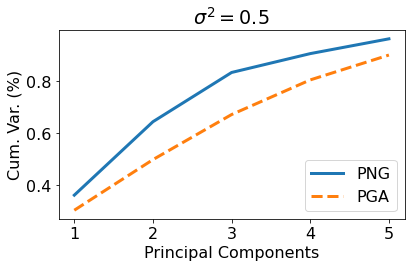

In [35]:
plt.rcParams.update({'font.size': 16})
plt.plot(np.linspace(1,n_c, n_c), np.mean(v_ratio_sig_PNG[:,3], axis = 0), '-', linewidth=3)
plt.plot(np.linspace(1,n_c, n_c), np.mean(v_ratio_sig_PGA[:,3], axis = 0), '--', linewidth=3)
plt.xlabel('Principal Components')
plt.ylabel('Cum. Var. (%)')
plt.legend(['PNG', 'PGA'], loc='lower right')
plt.title(r'$\sigma^2=$'+'{}'.format(s_vec[3]))
plt.tight_layout()
#plt.savefig('var_sig.pdf')
plt.show()

In [ ]:
np.save('simulation.npy', {'ratio_proj':v_ratio_sig_proj, 
                           'ratio_geod':v_ratio_sig_geod, 
                           'ratio_PGA':v_ratio_sig_PGA, 
                           'ratio_PNG':v_ratio_sig_PNG})